# **Практическое задание №2_Часть 1 . Синтетические данные**



# **Import библиотек**

In [977]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from  sklearn.pipeline  import  make_pipeline 

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

from sklearn.metrics import f1_score

для рисунков на черном фоне

In [978]:
plt.style.use('dark_background')

# **Синтетические данные**

создание функции

In [979]:
#функция создает одномерные данные от входных данных X
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

Визуализируем данные

In [980]:
#функция для построения графиков
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()


## Линейная зависимость

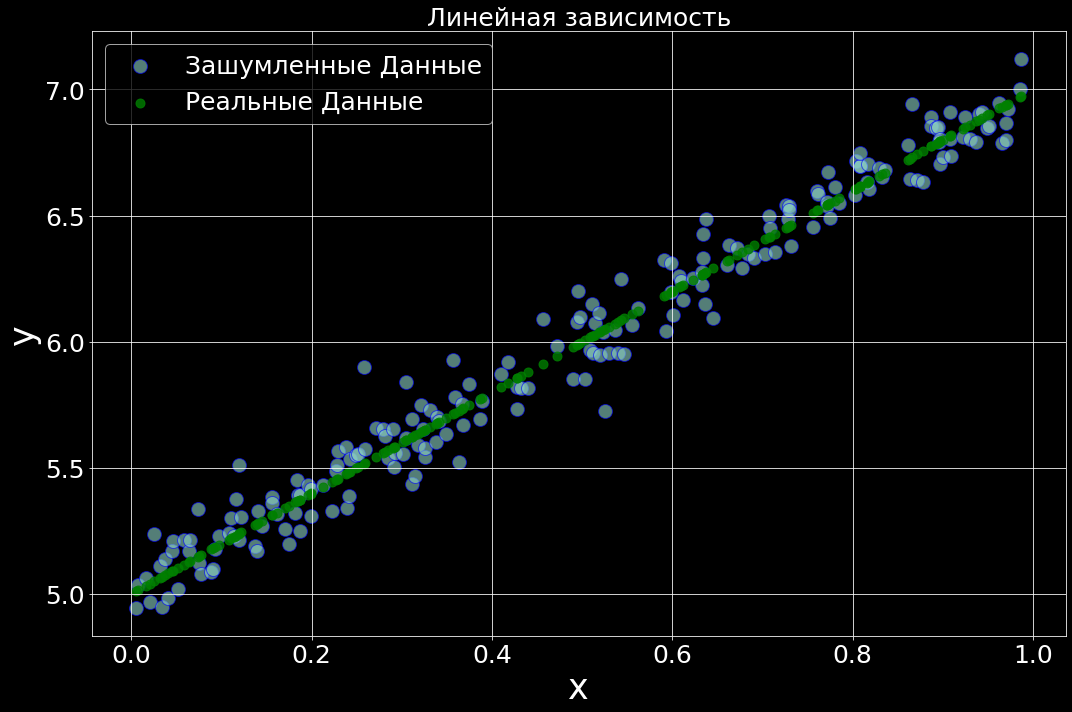

In [981]:
noise_power = 0.1

y, y_true, x = dataset(a = 2, b = 5,
                       f = None,  N = 200,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

### Линейная регрессия

Для того, чтобы выделить из входных данных тренировочную и тестовую выборку запишем следующую функцию. Функция будет иметь входные аргументы:
* `x,y` - входные данные и метки;
* `train_size` - размер тренировочной части;
* `test_size`  - размер тестовой части;
* `random_state` - состояние генератора случайных чисел; 
* `shuffle` - необходимость перемешивания данных.

In [982]:
#создаем функцию для разбития данных на обучающую и тестовую выборки
#модуль train_test_split можно импортировать из sklearn
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )


(100, 1) (100,) (40, 1) (40,) (60, 1) (60,)
(140, 1) (140,) (60, 1) (60,)


In [983]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(140, 1) (140,) (60, 1) (60,)


In [984]:
#запишем функцию инициализации весовых параметров
def init_weights(W_shape, add_bias = True, random_state = 42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))    
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

In [985]:
#Запишем функции предсказания и расчета значений функции потерь. Отметим, что для учета смещения мы будем добавлять единичный столбец к входным данным.
def predict( X, W, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return  np.dot(X_full,W)

def loss_func(yhat, y):
    return np.square(yhat - y)  

Протестируем функции

In [986]:
x_train[:1]

array([[0.44015249]])

In [987]:
y_train[:1]

array([5.81497206])

In [988]:
x_test[:1]

array([[0.89721576]])

In [989]:
y_test[:1]

array([6.80201197])

In [990]:
weights = init_weights(x.shape[1])
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[0.         0.49671415]
predict [0.21862997],
ground truth [4.94304176],
loss: [22.32006675]


Посмотрим на график того как меняется функция потерь в зависимости от отклонения (мультипликативного) оценки результата от его истинного значения.

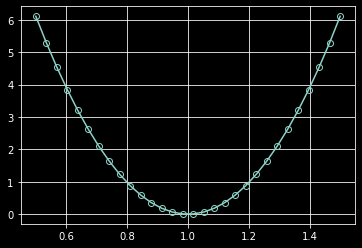

In [991]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 30)
yhat = decline* y[0]
loss = loss_func(yhat, y[0])
plt.plot(decline,loss,'-o', mfc = 'none'); plt.grid(); 

In [992]:
# функция оптимизациии весов с помощью градиентного спуска 
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  

Проведем расчет градиента ошибки

In [993]:
yhat = predict(x_train[0], weights)

grad = grad_loss(yhat, y[0], x[0])
print(grad)

[-9.44882358 -0.05217751]


Проведем оптизицаию методом градиентного спуска

In [994]:
# функция обновления весов
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

Обновим весовые параметры

In [995]:
lerning_rate = 0.1

weights = update_weights(grad, weights, lerning_rate)
print(weights)

[0.94488236 0.5019319 ]


In [996]:
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[0.94488236 0.5019319 ]
predict [1.16580894],
ground truth [4.94304176],
loss: [14.26748781]


Создадим процедуру обучения. Процедура будет повторять порцесс пересчета весов методом градиентного спуска заданое число раз (epochs).

In [997]:
# Создадим функцию обучения
def fit(X, y, learning_rate, weights = None,  epochs=30):

    if weights is None: weights = init_weights(X.shape[1])
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X) 
        weights = update_weights(grad, weights, lerning_rate)  
        cost[i] = loss_func(yhat,  y).mean()
                
    return weights, cost

Протестируем обучение

In [998]:
weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=10)

In [999]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);  

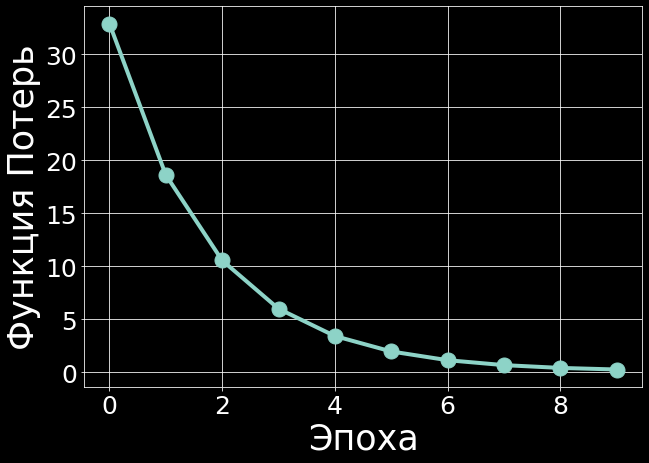

In [1000]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

Проверим как точно предсказывает наша функция

In [1001]:
# Метрика R2- соотвествует относительной среднеквадратичной ошибке
def r2_score(yhat, y):    
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

In [1002]:
predicts = predict( x_test,weights,)

r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.5791493707206489, 0.5175270192344381)

Модель работает не очень хорошо, так как R2=0.58 (Чем меньше средняя квадратичная ошибка, тем R2 больше (ближе к единице), тем выше качество модели.)

Посмотрим на то, какая интерпретация может быть у предсказанных и заданных данных.

In [1003]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

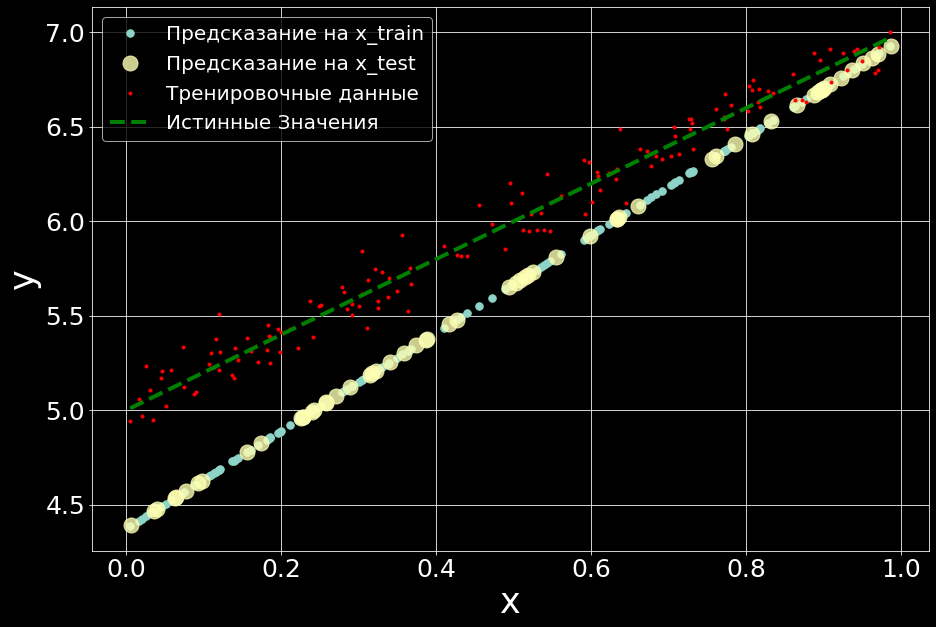

In [1004]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

Линейная регресия работает плохо, что видно на диаграмме и показатель R2 = 0.58 (Чем меньше средняя квадратичная ошибка, тем R2 больше (ближе к единице), тем выше качество модели.) 

In [1005]:
# веса
weights

array([4.37369057, 2.58943252])

In [1006]:
# визуализируем веса
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels );

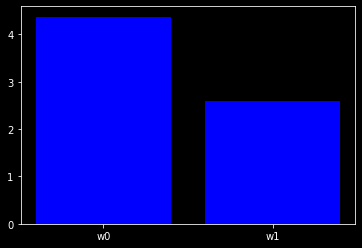

In [1007]:
vis_weigths(weights)

Запишем функцию для генерации минибатчей заданного размера.

In [1008]:
# Запишем функцию для генерации батчей заданного размера batch_size
def load_batch(X,y, batch_size = 50):
    idxs = np.arange(y.size)
    np.random.shuffle(idxs)

    for i_batch in range(0,y.size,batch_size):
        idx_batch = idxs[i_batch:i_batch+batch_size]
        x_batch   = np.take(X, idx_batch,axis=0)
        y_batch   = np.take(y, idx_batch)
        yield  x_batch, y_batch

In [1009]:
#запишем функцию оптимизации методом стохастического градиентного спуска.
BATCH = 10

def fit_SGD(X, y, lerning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    
    if random_state: np.random.seed(random_state)

    if weights is None: weights = init_weights(X.shape[1])
    if batch_size is None or batch_size>y.size : batch_size = y.size
    n_batches = y.size//batch_size
    
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        loss = 0
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): 

            yhat    = predict(x_batch, weights)
            grad    = grad_loss(yhat,  y_batch, x_batch) 
            weights = update_weights(grad, weights, lerning_rate) #backward 
            loss   += loss_func(yhat,  y_batch).mean()

            if cnt>= n_batches:
                break
        cost[i] = loss/n_batches

    return weights, cost

In [1010]:
weights = init_weights(x_train.shape[1], random_state=42)

weights, cost = fit_SGD(x_train, y_train, lerning_rate=0.1, batch_size = 10,  epochs=10)

predicts = predict(x_test, weights, )
r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.9689388250224398, 0.9716279414190838)

In [1011]:
weights

array([4.95891746, 2.08491764])

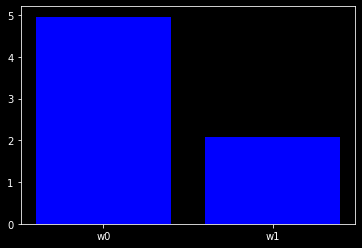

In [1012]:
vis_weigths(weights)

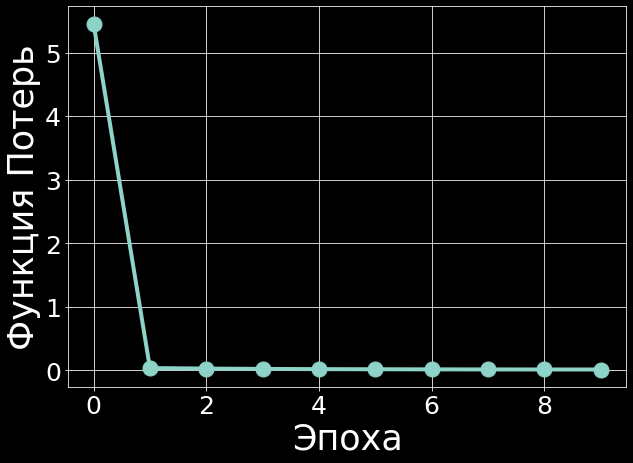

In [1013]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

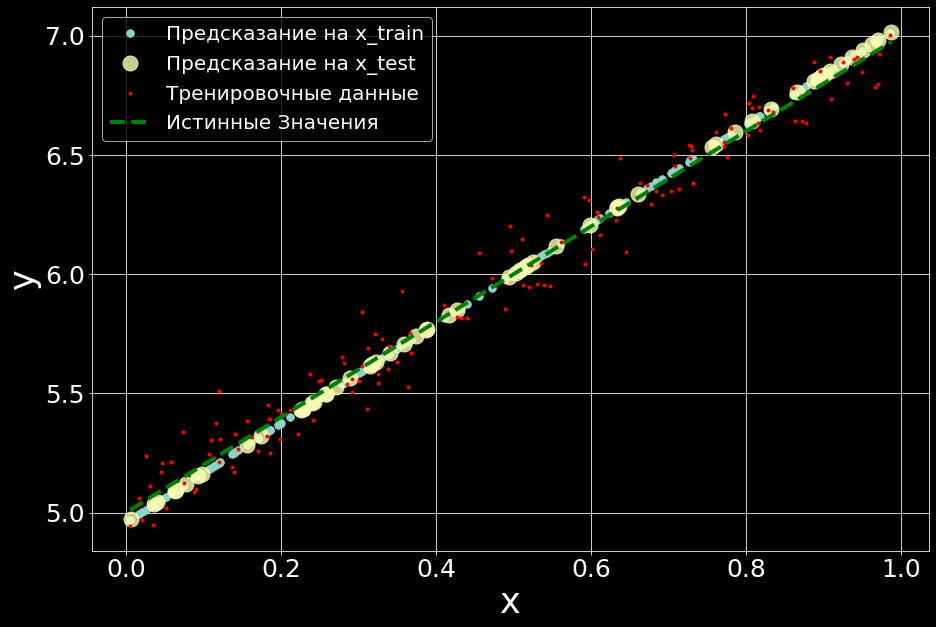

In [1014]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

Вывод: Линейная регрессия работает намного лучше



Объеденим все наши часть в один класс линейной регресии.

In [1015]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

## **Полиномальная Зависимость**

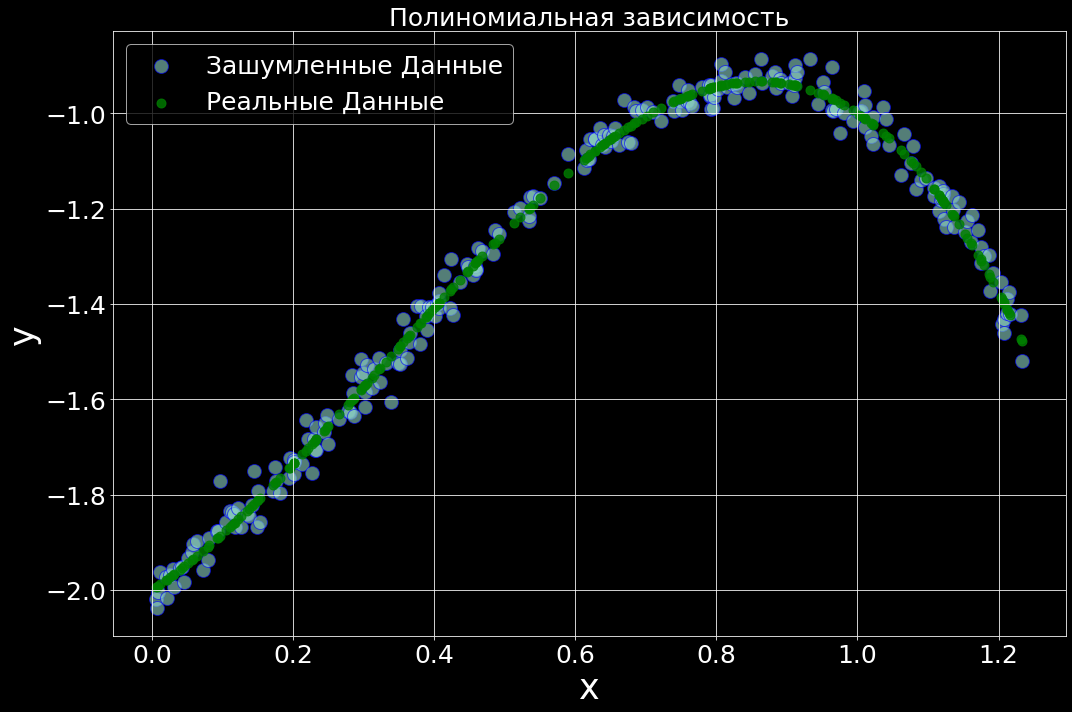

In [1016]:
noise_power = 0.03

y, y_true, x = dataset(a = [1,2,-2], b = -2,
                       f = None,  N = 250,
                       x_max =1.25, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

In [1017]:
# разобьем данные на тестовые и обучающие
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    

In [1018]:
regr_poly_lin = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
regr_poly_lin.fit(x_train, y_train)

In [1019]:
# визуализируем данные
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

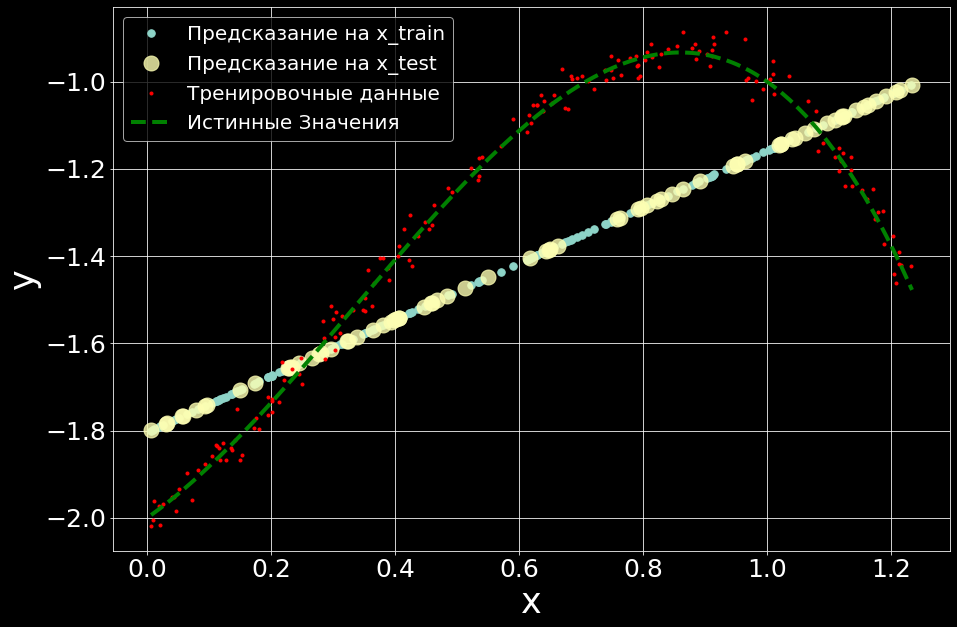

In [1020]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin)

### Полиномиальная регрессия

In [1021]:
#реализуем полиномальную регрессию
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T


In [1022]:
x_ = to_polynom(x, order = 4) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

In [1023]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [1024]:
regr_poly.fit(x_train, y_train)

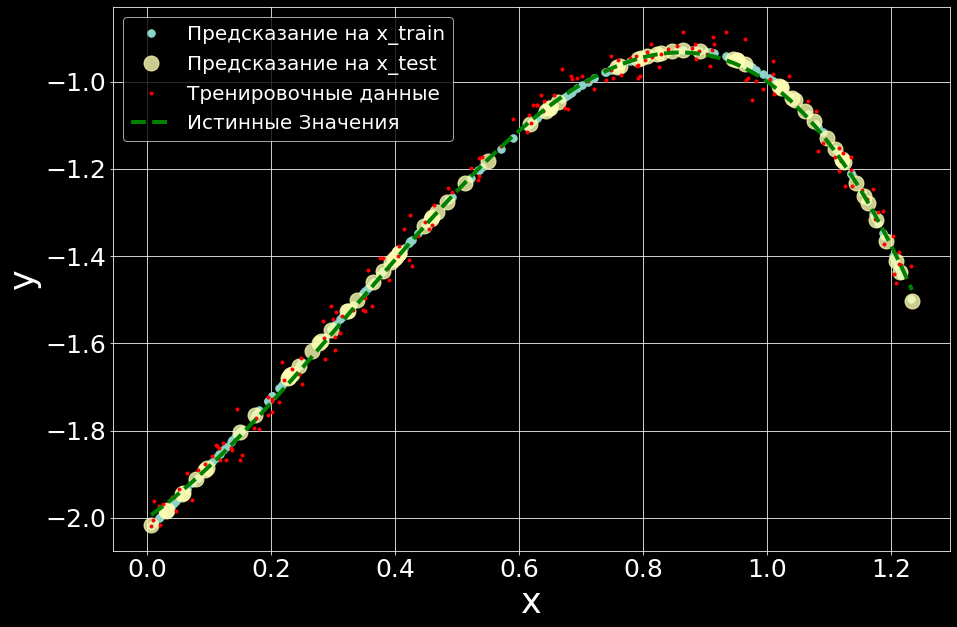

In [1025]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)

Вывод: регрессия работает хорошо при полиноме 4 степени

## **Гармоническая зависимость**

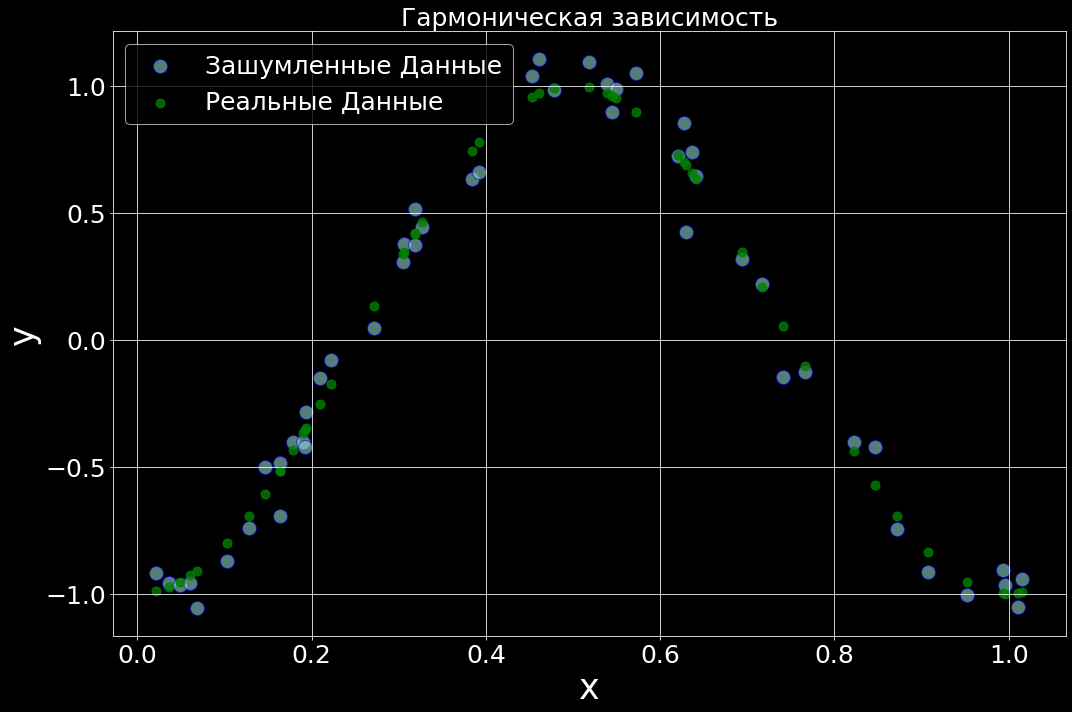

In [1026]:
y, y_true, x = dataset(a = 2*np.pi,
                       b = np.pi, f = np.cos,  
                       N = 50, x_max =np.pi/3, 
                       noise_power = 0.1, seed = 42)
vis_data(y, y_true,x, 'Гармоническая зависимость')

In [1027]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(35, 1) (35,) (15, 1) (15,)


Train Score = 0.00


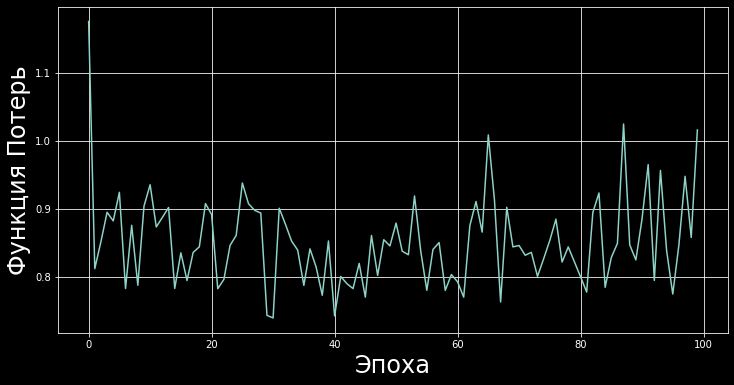

In [1028]:
#визуализируем данные
regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

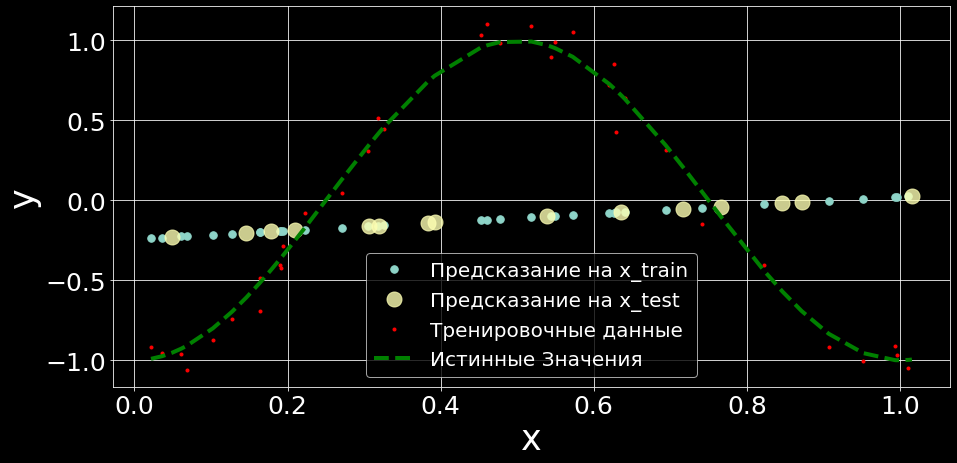

In [1029]:
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_harm)

Линейная регрессия работает плохо

In [1030]:
w, b = regr_harm.get_w_and_b()
print(w,b)

[0.26398754] -0.24167518488441947


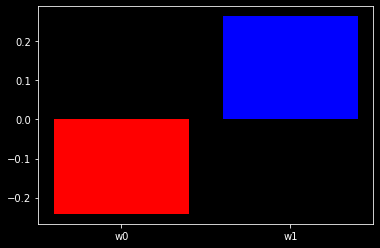

In [1031]:
vis_weigths(np.hstack([b,w]))

Полиномиальная регрессия

In [1032]:
#создадим набор данных
order  = 7

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

0         1         2         3             4             5  \
31  0.190407  0.036255  0.006903  0.001314  2.502711e-04  4.765328e-05   
32  0.640731  0.410536  0.263043  0.168540  1.079887e-01  6.919167e-02   
33  0.036012  0.001297  0.000047  0.000002  6.056345e-08  2.180985e-09   
34  0.326423  0.106552  0.034781  0.011353  3.705990e-03  1.209721e-03   

               6  
31  9.073502e-06  
32  4.433324e-02  
33  7.854071e-11  
34  3.948808e-04

Test Score = 0.51, Train Score = 0.72


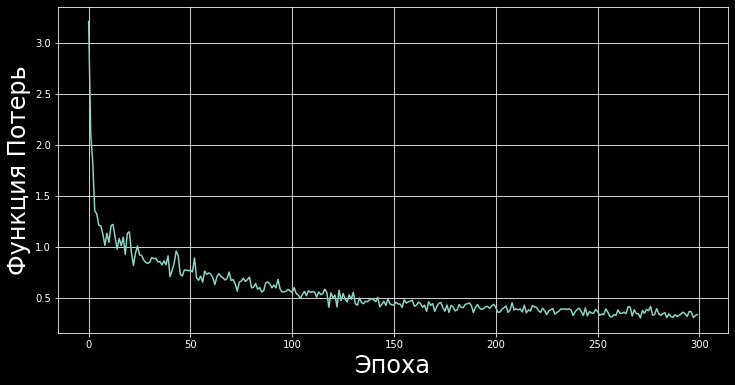

In [1033]:
regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

In [1034]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 2.27756294  0.44269009 -0.23140881 -0.33208391 -1.14199956 -1.1488273
 -0.40656519] -0.6940057735641603


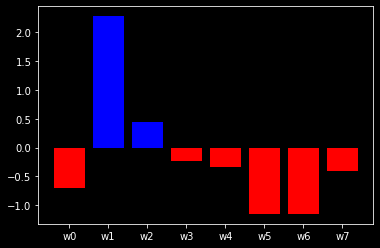

In [1035]:
vis_weigths(np.hstack([b,w]))

In [1036]:
np.sum(np.abs(w))

5.98113779718089

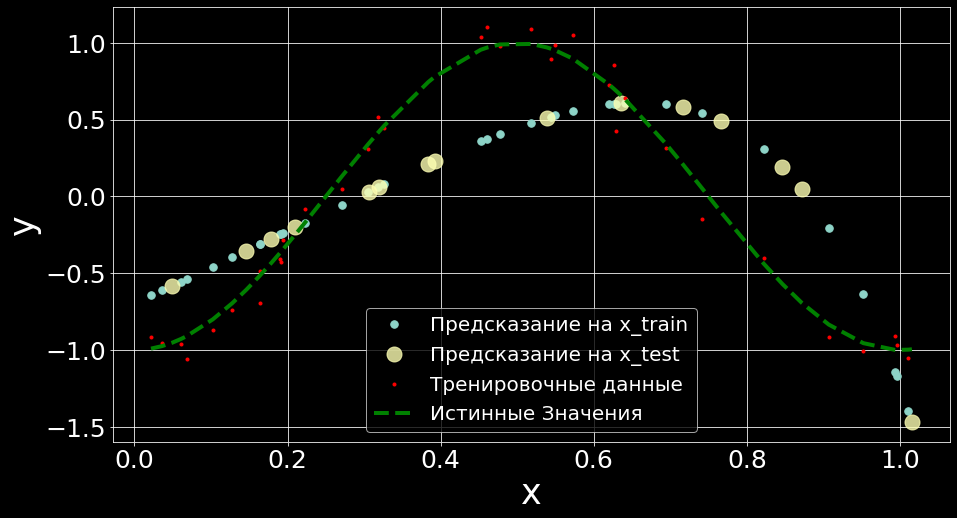

In [1037]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly)

Как видно из таблицы наши данные имеют слегка разный масштаб.  Для компенсации этого эффекта часто для данных применяют перемасштабирование - нормализацию


In [1038]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [1039]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [1040]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

In [1041]:
pd.DataFrame(x_test_scaled).tail(4)

0         1         2         3         4         5         6
11  1.290826  1.314799  1.202790  1.042037  0.873383  0.713301  0.567758
12 -0.818138 -0.806942 -0.701026 -0.607631 -0.541376 -0.496097 -0.464670
13  0.271678 -0.030467 -0.232614 -0.342675 -0.395187 -0.416225 -0.421213
14  0.860650  0.673987  0.441925  0.236037  0.072468 -0.051594 -0.143407

Test Score = 0.88, Train Score = 0.91


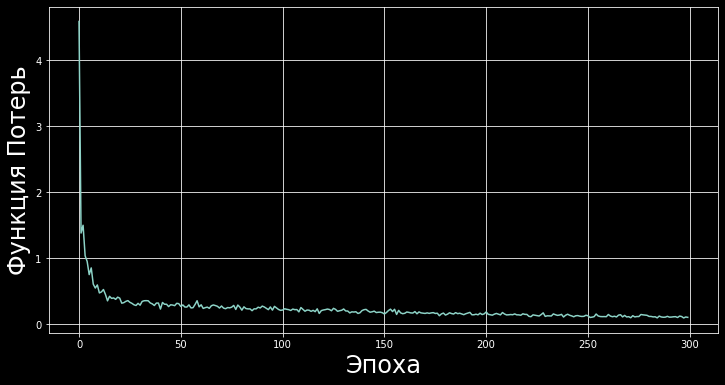

In [1042]:

regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

In [1043]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.67554719 -0.43951811 -0.80186215 -0.4123351  -0.70917697 -0.24298422
  0.91406129] -0.05887380866080671


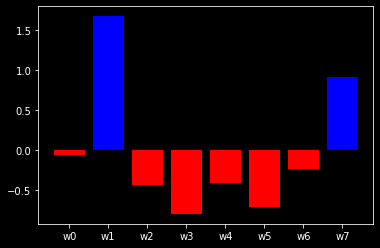

In [1044]:
vis_weigths(np.hstack([b,w]))

In [1045]:
np.sum(np.abs(w))

5.195485032331356

Посмотрим на результат.

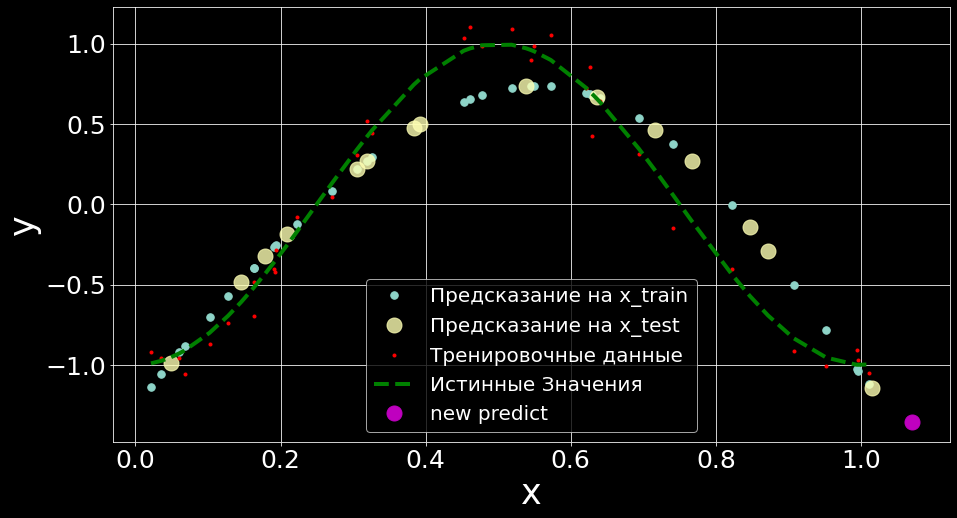

In [1046]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);

Вывод: выполнение нормализации данных значительно улучшило работу модели

## **Метод Наименьших Квадратов**

In [1047]:
order = 7
x_train_ls = to_polynom(x_train, order=order, add_bias=True)
x_test_ls  = to_polynom(x_test,  order=order, add_bias=True)
weights  = np.linalg.lstsq(x_train_ls, y_train, rcond=None)[0] #including bias

In [1048]:
weights

array([  -0.83156595,   -6.30429073,   77.05553926, -236.09854381,
        465.4135124 , -667.7206397 ,  536.36311687, -168.86766269])

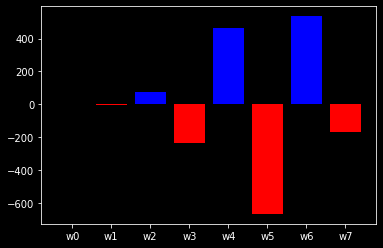

In [1049]:
vis_weigths(weights)

In [1050]:
np.sum(np.abs(weights))

2158.654871406652

In [1051]:
def polyval(x,weights):
    return np.sum([np.power(x,i)*wi for i, wi in enumerate(weights) ],axis = 0) # including bias!

In [1052]:
print(f"Test score: {r2_score(y_test, polyval(x_test,weights).squeeze()):.2f}, Train score: {r2_score(y_train, polyval(x_train,weights).squeeze()):.2f}")

Test score: 0.97, Train score: 0.99


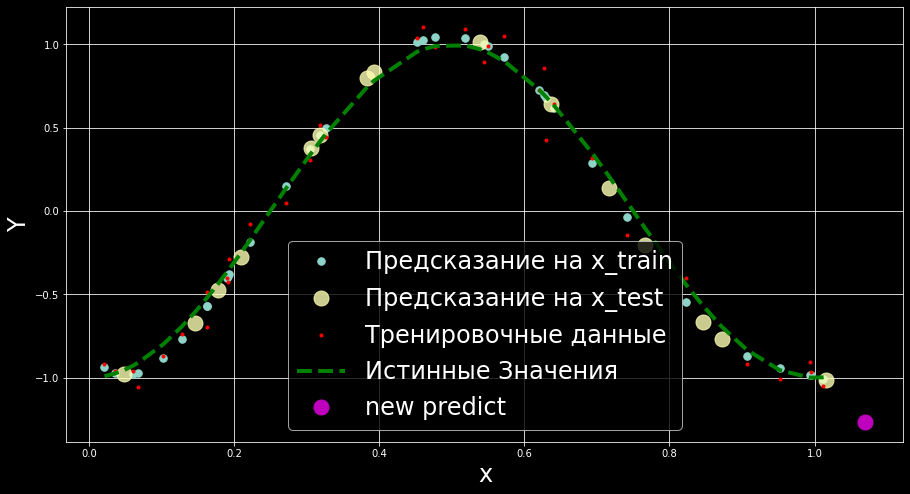

In [1053]:
#визуализируем данные
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], polyval(x_train, weights),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], polyval(x_test, weights),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         polyval([1.07], weights), 
         'mo',  label = 'new predict',
        markersize = 15 )

plt.grid()
plt.legend(fontsize = 24)
plt.xlabel('x', fontsize = 24)
plt.ylabel('Y', fontsize = 24)
plt.show()

Аналитическое решение методом наименьших квадратов дало результаты лучше чем численное

Однако, градиентный спуск позволяет поднять точность на тестовых данных.

##  **Регуляризация линейной регрессии**

### **Регуляризация Тихонова**

Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss` и `update`.

In [1054]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  


Test Score = 0.86, Train Score = 0.90


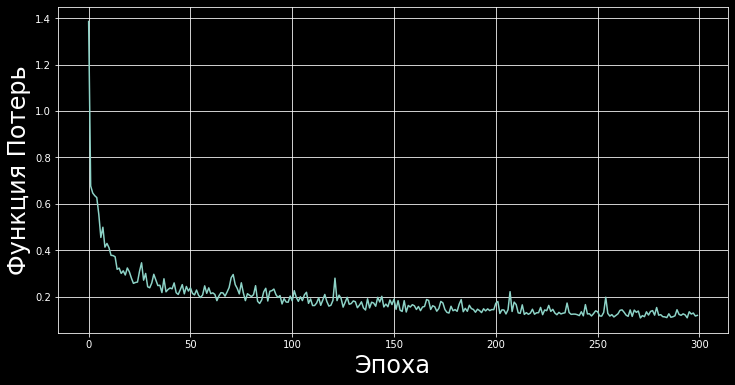

In [1055]:
regr_l2 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l2.score(x_test_, y_test):.2f}, Train Score = {regr_l2.score(x_train_, y_train):.2f}')
regr_l2.plot_cost()

In [1056]:
w, b = regr_l2.get_w_and_b()
print(w,b)

[ 5.25300361 -0.83406523 -2.66775591 -2.10150569 -1.55184256 -0.04797413
  2.13375719] -1.2246068419129337


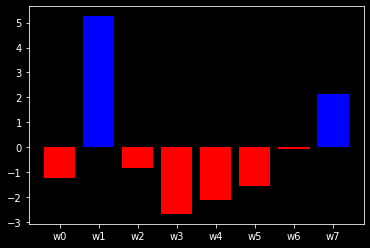

In [1057]:
vis_weigths(np.hstack([b,w]))

In [1058]:
np.sum(np.abs(w))

14.589904317254307

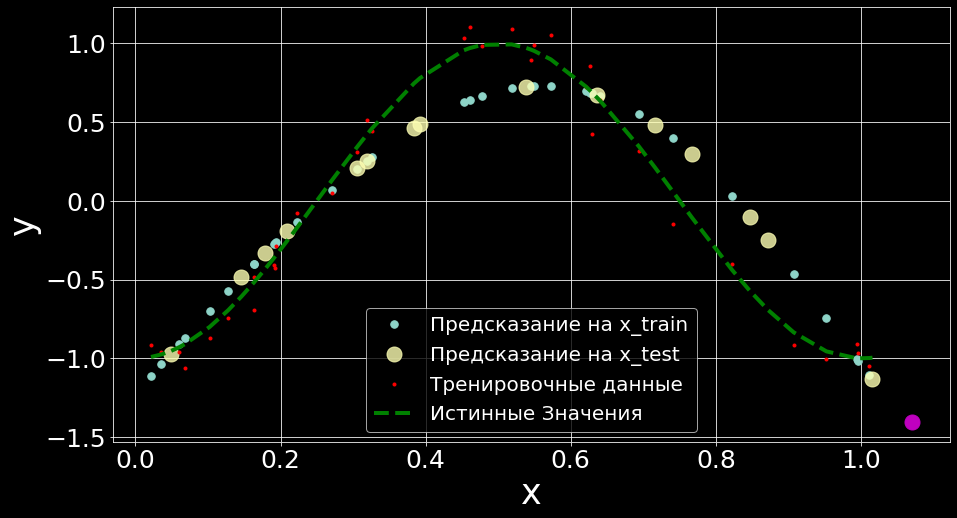

In [1059]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l2)

plt.plot([1.07], 
         regr_l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

Вывод : протестировав показатель l2 удалось повысить качество модели


### **Эластичная регуляризация**

In [1060]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

Test Score = 0.92, Train Score = 0.91


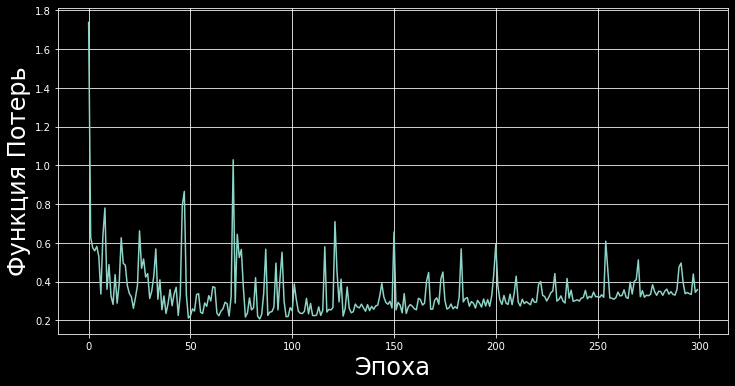

In [1061]:
regr_l1l2 = ElasticRegression(learning_rate=0.5,
                         epochs=300,batch_size=10,
                         l1_penalty = 0.00001,l2_penalty = 0.005 )
regr_l1l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l1l2.score(x_test_, y_test):.2f}, Train Score = {regr_l1l2.score(x_train_, y_train):.2f}')
regr_l1l2.plot_cost()

In [1062]:
w, b = regr_l1l2.get_w_and_b()
print(w,b)

[ 6.45130011 -1.38117854 -3.95426535 -3.10877029 -1.81695604  0.55111246
  3.57241889] -1.5062705801756162


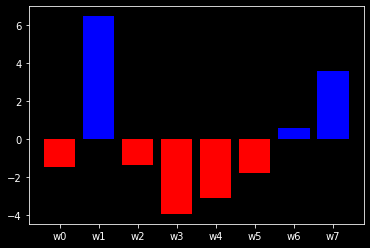

In [1063]:
vis_weigths(np.hstack([b,w]))

In [1064]:
np.sum(np.abs(w))

20.836001669374117

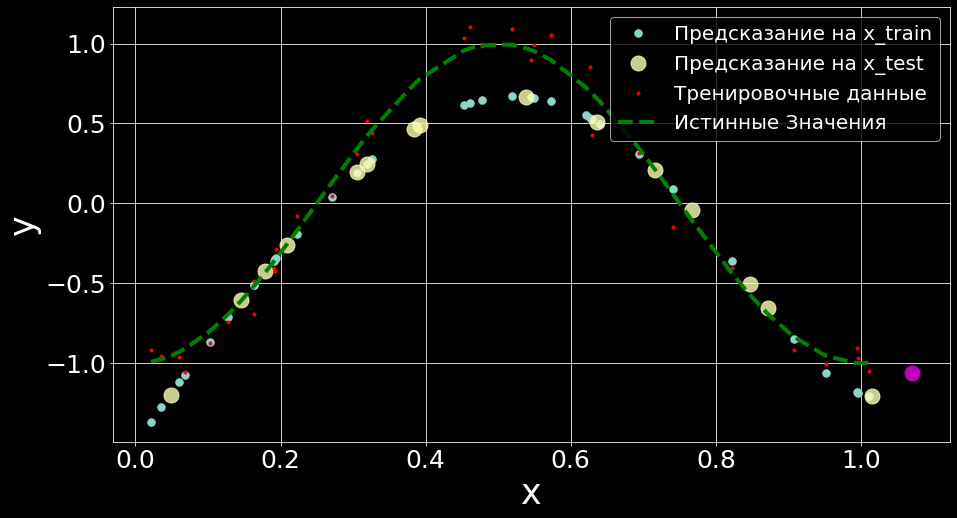

In [1065]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1l2)

plt.plot([1.07], 
         regr_l1l2.predict(to_polynom([1.075], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

При подборе параметров l1 (уменьшение) и l2 ( увеличение) удаловь повысить качество работы модели

### **Регуляризация L1**

Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss` и `update`.

In [1066]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

Test Score = 0.92, Train Score = 0.91


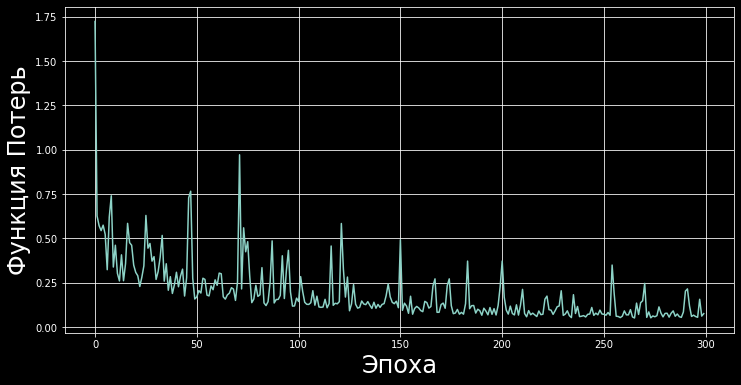

In [1067]:
regr_l1 = LassoRegression(learning_rate=0.50,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.0001)
regr_l1.fit(x_train_, y_train)

print(f'Test Score = {regr_l1.score(x_test_, y_test):.2f}, Train Score = {regr_l1.score(x_train_, y_train):.2f}')
regr_l1.plot_cost()

In [1068]:
w, b = regr_l1.get_w_and_b()
print(w,b)

[ 6.42470603 -1.37059605 -3.93919779 -3.09151304 -1.78753384  0.5430522
  3.53026234] -1.50357775541735


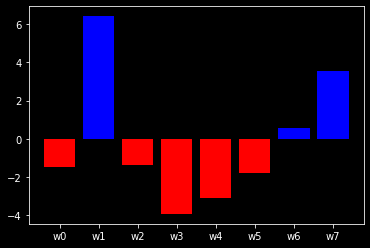

In [1069]:
vis_weigths(np.hstack([b,w]))

In [1070]:
np.sum(np.abs(w))

20.686861288738115

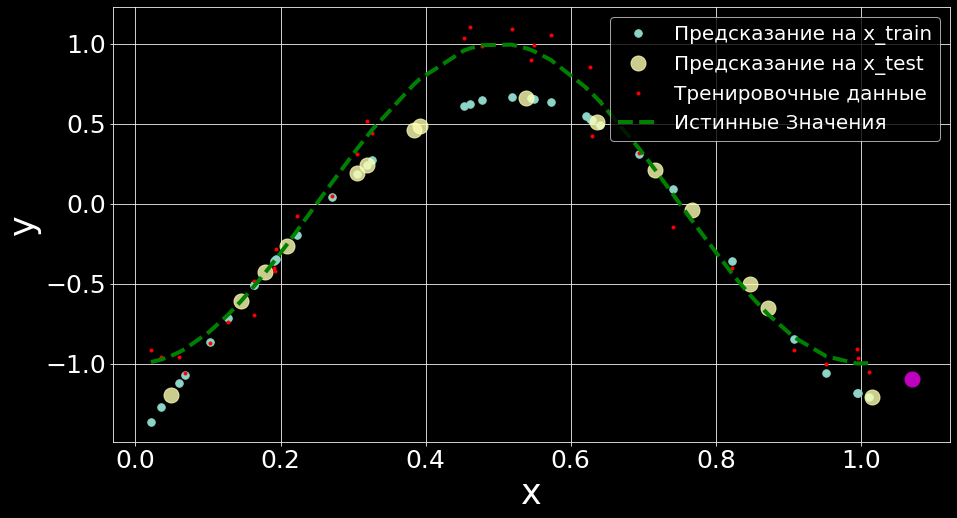

In [1071]:
# визуализируем модель
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1)

plt.plot([1.07], 
         regr_l1.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

После изменения парамерта l1  качество модели улучшилась на 0,02
